In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import json
import pandas as pd
import seaborn as sns
import anndata as ad
from scipy.stats import spearmanr, mannwhitneyu
from sksurv.preprocessing import OneHotEncoder
from lifelines import (CoxPHFitter, KaplanMeierFitter)
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test, proportional_hazard_test
import warnings
warnings.filterwarnings("ignore")


In [2]:
extension = 'svg'
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_5/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_5/{extension}/'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
adata = ad.read_h5ad("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/adatas/cells_final.h5ad")
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/neighborhood_color_map.json', 'r') as f:
    neighborhood_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/phenotype_color_map.json', 'r') as f:
    phenotype_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease_color_map.json', 'r') as f:
    disease_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease3_color_map.json', 'r') as f:
    disease3_color_map = json.load(f)
neighborhood_colors = [neighborhood_color_map[cat] for cat in list(adata.obs['cellcharter_CN'].cat.categories)]
neighborhood_colors = ListedColormap(neighborhood_colors)
phenotype_colors = [phenotype_color_map[cat] for cat in list(adata.obs['Phenotype4'].cat.categories)]
phenotype_colors = ListedColormap(phenotype_colors)
disease_colors = [disease_color_map[cat] for cat in list(adata.obs['disease2'].cat.categories)]
disease_colors = ListedColormap(disease_colors)
disease3_colors = [disease3_color_map[cat] for cat in list(adata.obs['disease3'].cat.categories)]
disease3_colors = ListedColormap(disease3_colors)
pfs_color_map = {'short_PFS': sns.color_palette('dark')[6], 'long_PFS': sns.color_palette('dark')[8]}

In [3]:
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
nbh_enrichment = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/clinical_correlation/nhood_enrichment_patients.csv')
nbh_enrichment.set_index('patient_ID', inplace=True)
nbh_enrichment2 = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/clinical_correlation/immune_COZI_normalized_scores_patients.csv')
nbh_enrichment2.set_index('patient_ID', inplace=True)
nbh_enrichment3 = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/clinical_correlation/nhood_enrichment_images.csv')
nbh_enrichment3.set_index('image_ID', inplace=True)
adata = adata[adata.obs['patient_ID'].isin(md['IMC label'])]
adata.obs['PFS_group'] = adata.obs['patient_ID'].map(md.set_index('IMC label')['Short_long PFS (< or >  2 yrs)'])
adata.obs['PFS_group'] = adata.obs['PFS_group'].astype('category')

In [4]:
nbh_enrichment2.rename(columns={'CD8+Tcells_Plasma Cells/MM cells': 'CD8 T*PCs', 'Plasma Cells/MM cells_CD8+Tcells': 'PCs*CD8 T','Plasma Cells/MM cells_CD4+Tcells': 'PCs*CD4 T',
                                'CD4+Tcells_Plasma Cells/MM cells': 'CD4 T*PCs', 'Plasma Cells/MM cells_Dendritic Cells': 'PCs*DCs', 'Dendritic Cells_Plasma Cells/MM cells': 'DCs*PCs',
                                'Plasma Cells/MM cells_Neutrophils': 'PCs*Neutrophils', 'Neutrophils_Plasma Cells/MM cells': 'Neutrophils*PCs',
                                'Plasma Cells/MM cells_activated Macrophages/Monocytes': 'PCs*HLA-DR+ Macs/monos', 'activated Macrophages/Monocytes_Plasma Cells/MM cells': 'HLA-DR+ Macs/monos*PCs',
                                'Plasma Cells/MM cells_Macrophages/Monocytes': 'PCs*Macs/monos', 'Macrophages/Monocytes_Plasma Cells/MM cells': 'Macs/monos*PCs',
                                'Plasma Cells/MM cells_Plasma Cells/MM cells': 'PCs*PCs', 'CD8+Tcells_CD8+Tcells': 'CD8 T*CD8 T', 'CD4+Tcells_CD4+Tcells': 'CD4 T*CD4 T'}, inplace=True)

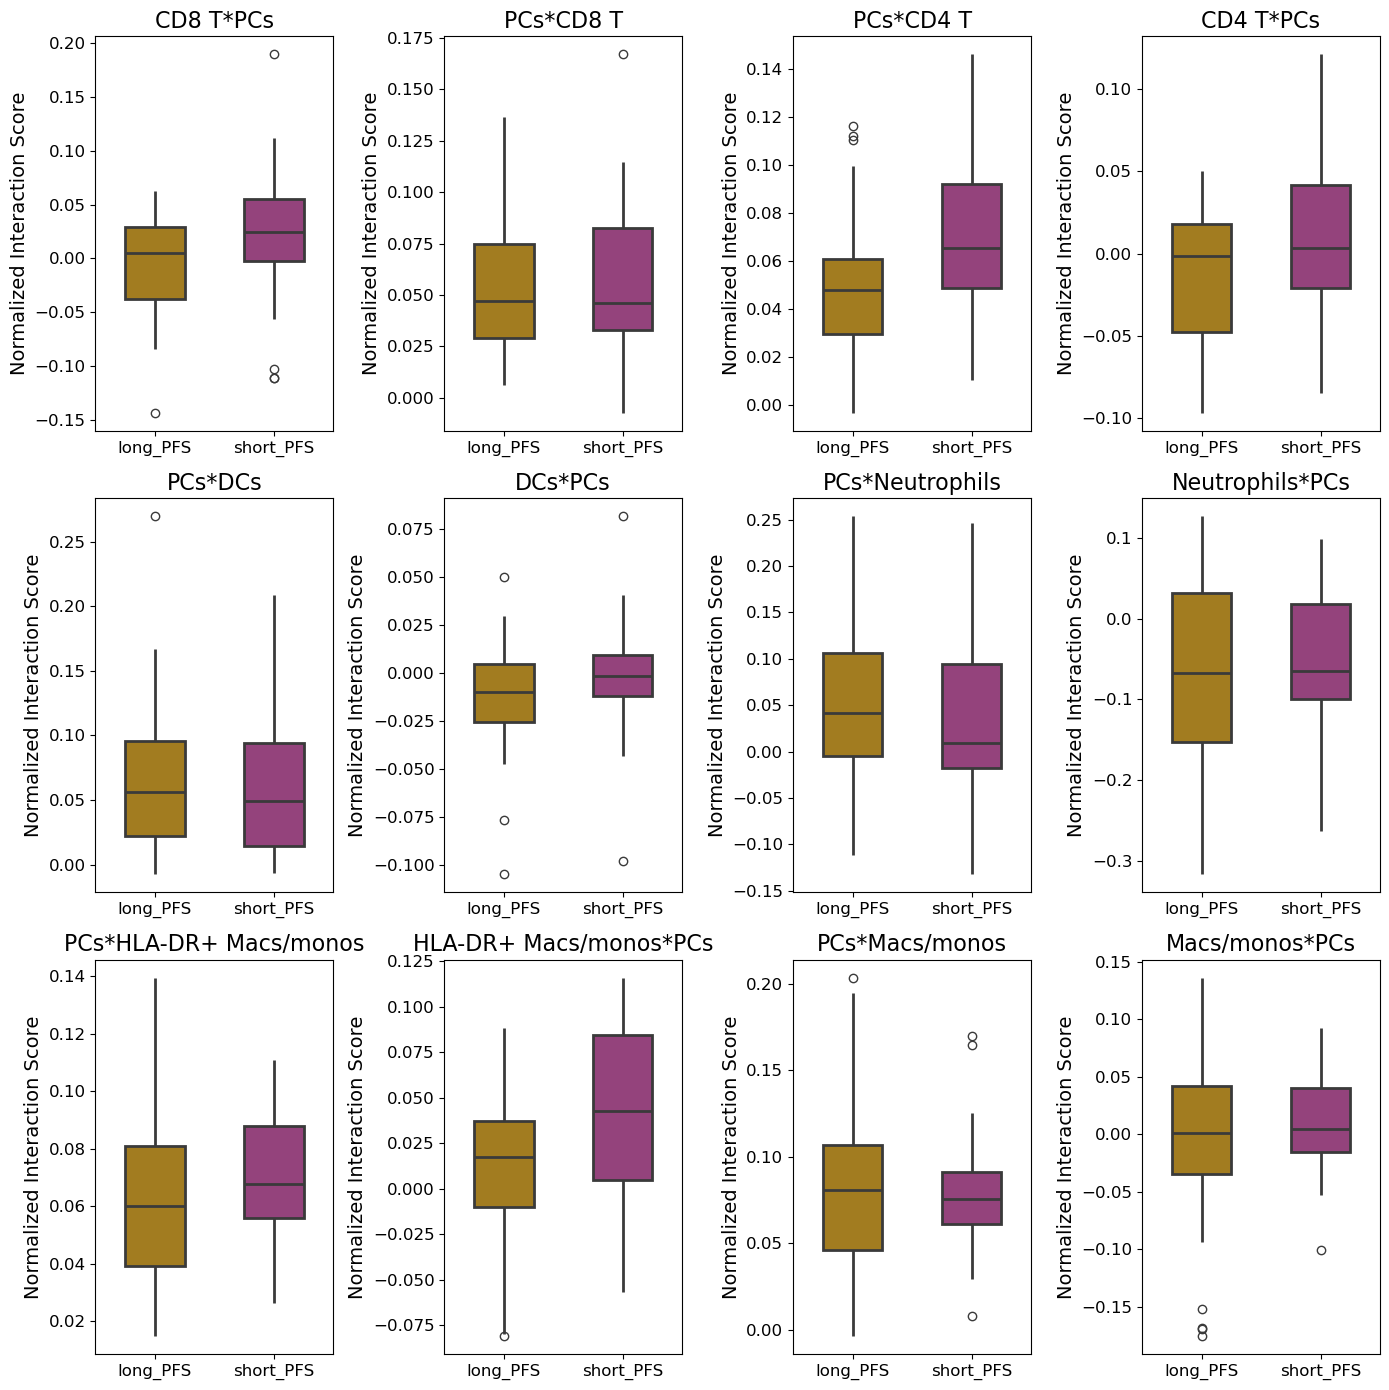

In [5]:
fig, ax = plt.subplots(3, 4, figsize=(14, 14))
order = ['long_PFS', 'short_PFS']
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='CD8 T*PCs', palette=pfs_color_map, ax=ax[0,0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*CD8 T', palette=pfs_color_map, ax=ax[0,1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*CD4 T', palette=pfs_color_map, ax=ax[0,2], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='CD4 T*PCs', palette=pfs_color_map, ax=ax[0,3], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*DCs', palette=pfs_color_map, ax=ax[1,0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='DCs*PCs', palette=pfs_color_map, ax=ax[1,1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*Neutrophils', palette=pfs_color_map, ax=ax[1,2], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='Neutrophils*PCs', palette=pfs_color_map, ax=ax[1,3], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*HLA-DR+ Macs/monos', palette=pfs_color_map, ax=ax[2,0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='HLA-DR+ Macs/monos*PCs', palette=pfs_color_map, ax=ax[2,1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*Macs/monos', palette=pfs_color_map, ax=ax[2,2], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='Macs/monos*PCs', palette=pfs_color_map, ax=ax[2,3], order=order, showcaps=False, linewidth=2, width=0.5)
for axi in ax.flatten():
    axi.set_xlabel('')
    #titles = axi.get_ylabel().split('*')
    axi.set_title(axi.get_ylabel(), fontsize=16)
    axi.set_ylabel('Normalized Interaction Score', fontsize=14)
    axi.set_xticklabels(axi.get_xticklabels(), fontsize=12)
    axi.set_yticklabels(axi.get_yticklabels(), fontsize=12)
plt.tight_layout()

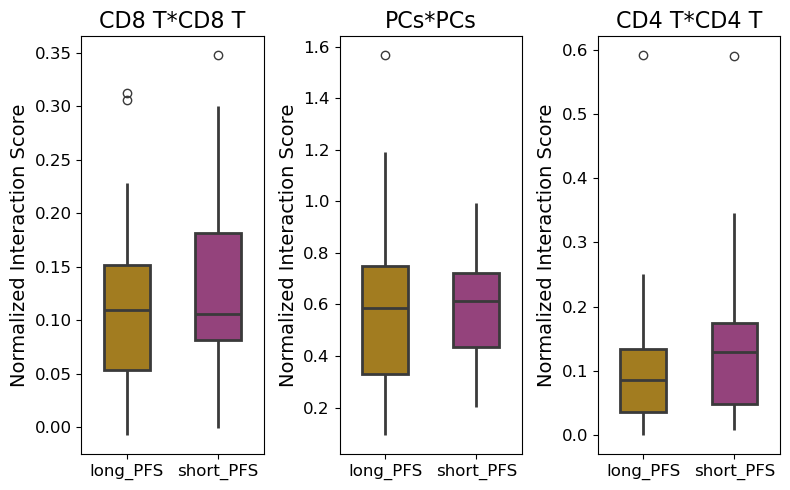

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(8, 5))
order = ['long_PFS', 'short_PFS']
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='CD8 T*CD8 T', palette=pfs_color_map, ax=ax[0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*PCs', palette=pfs_color_map, ax=ax[1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='CD4 T*CD4 T', palette=pfs_color_map, ax=ax[2], order=order, showcaps=False, linewidth=2, width=0.5)
for axi in ax.flatten():
    axi.set_xlabel('')
    #titles = axi.get_ylabel().split('*')
    axi.set_title(axi.get_ylabel(), fontsize=16)
    axi.set_ylabel('Normalized Interaction Score', fontsize=14)
    axi.set_xticklabels(axi.get_xticklabels(), fontsize=12)
    axi.set_yticklabels(axi.get_yticklabels(), fontsize=12)
plt.tight_layout()

In [7]:
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
md['PCs*CD4 T'] = md['IMC label'].map(nbh_enrichment2['PCs*CD4 T'])
md['CD4 T*PCs'] = md['IMC label'].map(nbh_enrichment2['CD4 T*PCs'])
md['PCs*CD8 T'] = md['IMC label'].map(nbh_enrichment2['PCs*CD8 T'])
md['CD8 T*PCs'] = md['IMC label'].map(nbh_enrichment2['CD8 T*PCs'])
md['PCs*PCs'] = md['IMC label'].map(nbh_enrichment2['PCs*PCs'])
md['CD4 T*CD4 T'] = md['IMC label'].map(nbh_enrichment2['CD4 T*CD4 T'])
md['CD8 T*CD8 T'] = md['IMC label'].map(nbh_enrichment2['CD8 T*CD8 T'])

In [8]:
md['PCs*CD4 T_score'] = np.where(md['PCs*CD4 T'] > 0.06, 'high', 'low')

In [9]:
md

,IMC label,Cohort,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),PFS from first time of diagnosis until relapse (days),Event (Death) occurred,OS (days),Short_long PFS (< or > 2 yrs),...,>=10 lesions,Days to progression from noBD/SMM to BD,PCs*CD4 T,CD4 T*PCs,PCs*CD8 T,CD8 T*PCs,PCs*PCs,CD4 T*CD4 T,CD8 T*CD8 T,PCs*CD4 T_score
0,IMC01,UB,Male,67.0,True,1766.0,3424.0,True,3313.0,long_PFS,...,False,NaN,0.042121,0.004406,0.024115,0.025990,0.242202,0.088242,0.159876,low
1,IMC07,UB,Male,66.0,True,1448.0,1766.0,True,2891.0,long_PFS,...,False,1858.0,0.018482,-0.044952,0.066477,-0.071258,0.501424,0.017893,0.093909,low
2,IMC08,B,Female,65.0,True,833.0,4050.0,True,3733.0,long_PFS,...,False,NaN,0.088885,-0.069387,0.074322,-0.022294,0.864469,0.144405,0.034174,high
3,IMC09,B,Male,58.0,True,1337.0,1337.0,True,2062.0,long_PFS,...,False,NaN,0.051136,0.028466,0.039863,0.032868,0.153067,0.117588,0.130595,low
4,IMC12,UB,Female,79.0,True,258.0,258.0,True,1370.0,short_PFS,...,False,1235.0,0.089168,-0.006925,0.089354,0.006612,0.532127,0.090778,0.076824,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,IMC90.1,B,Female,58.0,True,1536.0,1536.0,False,3418.0,long_PFS,...,False,NaN,0.089745,-0.022097,0.018946,0.001777,1.063415,0.134327,0.116729,high
59,IMC92,B,Female,54.0,False,6033.0,NaN,False,6033.0,long_PFS,...,False,NaN,0.047854,0.049962,0.010891,0.047208,0.413147,0.034275,0.043665,low
60,IMC93,B,Female,71.0,True,2375.0,2375.0,True,3954.0,long_PFS,...,True,NaN,0.051150,-0.006210,0.058476,0.018314,0.610411,0.071651,0.139343,low
61,IMC95,B,Female,58.0,True,1966.0,1966.0,True,4847.0,long_PFS,...,False,NaN,-0.000059,0.010935,0.018946,0.024765,0.093215,0.021616,-0.007629,low


In [10]:
md['PCs*CD4 T'].describe()

count    63.000000
mean      0.061000
std       0.035251
min      -0.003157
25%       0.038854
50%       0.054883
75%       0.089457
max       0.146197
Name: PCs*CD4 T, dtype: float64

In [23]:
md['CD4 T*PCs'].describe()

count    63.000000
mean     -0.005016
std       0.046649
min      -0.096902
25%      -0.036851
50%       0.002412
75%       0.023546
max       0.121263
Name: CD4 T*PCs, dtype: float64

In [11]:
md[md['PCs*CD4 T'] > 0.12]

,IMC label,Cohort,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),PFS from first time of diagnosis until relapse (days),Event (Death) occurred,OS (days),Short_long PFS (< or > 2 yrs),...,>=10 lesions,Days to progression from noBD/SMM to BD,PCs*CD4 T,CD4 T*PCs,PCs*CD8 T,CD8 T*PCs,PCs*PCs,CD4 T*CD4 T,CD8 T*CD8 T,PCs*CD4 T_score
12,IMC26,B,Male,60.0,True,188.0,188.0,False,3043.0,short_PFS,...,False,NaN,0.146197,0.020174,0.043180,0.052682,0.668491,0.217181,0.181696,high
37,IMC57,B,Male,47.0,True,588.0,588.0,False,1588.0,short_PFS,...,True,NaN,0.137517,-0.029864,0.045101,0.038597,0.992979,0.590608,0.347886,high
57,IMC89,B,Male,60.0,True,413.0,413.0,True,1842.0,short_PFS,...,True,NaN,0.136475,-0.084938,0.167027,-0.111337,0.908982,0.153973,0.300877,high


In [12]:
md[md['PCs*CD4 T'] < 0]

,IMC label,Cohort,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),PFS from first time of diagnosis until relapse (days),Event (Death) occurred,OS (days),Short_long PFS (< or > 2 yrs),...,>=10 lesions,Days to progression from noBD/SMM to BD,PCs*CD4 T,CD4 T*PCs,PCs*CD8 T,CD8 T*PCs,PCs*PCs,CD4 T*CD4 T,CD8 T*CD8 T,PCs*CD4 T_score
49,IMC77,B,Male,34.0,True,1000.0,1000.0,True,2328.0,long_PFS,...,False,NaN,-0.003157,0.009395,0.006105,0.051594,0.247182,0.011439,0.013382,low
61,IMC95,B,Female,58.0,True,1966.0,1966.0,True,4847.0,long_PFS,...,False,NaN,-0.000059,0.010935,0.018946,0.024765,0.093215,0.021616,-0.007629,low


Candidates for PCs*CD4T:

IMC26 (188 PFS)

IMC95 (1966 PFs)

In [20]:
md['CD8 T*PCs'].describe()

count    63.000000
mean      0.007021
std       0.058507
min      -0.143404
25%      -0.029186
50%       0.018314
75%       0.043421
max       0.189722
Name: CD8 T*PCs, dtype: float64

In [17]:
md[md['CD8 T*PCs'] > 0.1]

,IMC label,Cohort,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),PFS from first time of diagnosis until relapse (days),Event (Death) occurred,OS (days),Short_long PFS (< or > 2 yrs),...,>=10 lesions,Days to progression from noBD/SMM to BD,PCs*CD4 T,CD4 T*PCs,PCs*CD8 T,CD8 T*PCs,PCs*PCs,CD4 T*CD4 T,CD8 T*CD8 T,PCs*CD4 T_score
18,IMC33,B,Male,55.0,True,674.0,674.0,False,2471.0,short_PFS,...,False,NaN,0.057052,0.121263,0.051511,0.189722,0.784384,0.126557,0.081212,low
24,IMC42,B,Female,78.0,True,338.0,348.0,False,2083.0,short_PFS,...,False,NaN,0.048011,0.040698,0.072559,0.112301,0.436158,0.129268,0.267961,low
54,IMC85,UB,Male,72.0,True,312.0,312.0,False,3035.0,short_PFS,...,False,1875.0,0.082330,0.041955,0.018067,0.111593,0.722734,0.227340,0.089055,high


In [21]:
md[md['CD8 T*PCs'] < -0.12]

,IMC label,Cohort,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),PFS from first time of diagnosis until relapse (days),Event (Death) occurred,OS (days),Short_long PFS (< or > 2 yrs),...,>=10 lesions,Days to progression from noBD/SMM to BD,PCs*CD4 T,CD4 T*PCs,PCs*CD8 T,CD8 T*PCs,PCs*PCs,CD4 T*CD4 T,CD8 T*CD8 T,PCs*CD4 T_score
48,IMC75-1,B,Male,70.0,True,1097.0,1097.0,True,2490.0,long_PFS,...,True,NaN,0.047222,-0.0807,0.078307,-0.143404,0.736097,0.136281,0.312408,low


In [24]:
nbh_enrichment3 = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/clinical_correlation/nhood_enrichment_images.csv')

In [30]:
nbh_enrichment3

,image_ID,adaptive_immune*bone_vasculature,adaptive_immune*focal_pc_oxphos,focal_pc_oxphos*stroma_adipocyte,pc_myeloid*focal_pc_oxphos,bone_vasculature*focal_pc_oxphos,hypoxic_immune*focal_pc_oxphos,pfs
0,TS-373_IMC77_B_001.csv,-0.028929,0.015180,0.075013,0.058162,-0.034723,-0.010897,long_PFS
1,TS-373_IMC84_B_002.csv,0.019618,-0.083498,0.032083,0.129381,0.005177,-0.127793,long_PFS
2,TS-373_IMC60-1_B_001.csv,0.102850,0.043978,0.020682,0.029659,0.125435,0.012111,long_PFS
3,TS-373_IMC69_B_001.csv,0.007645,0.064552,0.014403,0.042520,0.077703,0.004834,long_PFS
4,TS-373_IMC45_B_002.csv,0.103517,0.086797,0.059144,0.124339,-0.026806,-0.109423,long_PFS
...,...,...,...,...,...,...,...,...
120,TS-373_IMC30_UB_001.csv,-0.003097,0.016548,0.138311,-0.006112,0.084231,-0.062258,short_PFS
121,TS-373_IMC44_B_001.csv,0.048075,-0.004505,0.168022,0.016759,0.034324,0.001164,short_PFS
122,TS-373_IMC80_B_002.csv,-0.027636,-0.024794,0.198270,-0.001174,0.038623,-0.045892,short_PFS
123,TS-373_IMC64_B_001.csv,0.021180,-0.062227,0.053457,0.114843,0.003921,-0.028336,short_PFS


In [31]:
image_scores = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/clinical_correlation/immune_COZI_normalized_scores_images.csv')

In [34]:
image_scores[image_scores['image_ID'] == 'TS-373_IMC26_B_001.csv'][['CD4+Tcells_Plasma Cells/MM cells', 'Plasma Cells/MM cells_CD4+Tcells']]

,CD4+Tcells_Plasma Cells/MM cells,Plasma Cells/MM cells_CD4+Tcells
71,0.019869,0.24958
